# Problem 1

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x,y),\\
\frac{\partial \hat u}{\partial x} = \pi cos(\pi x)sin(\pi y),\\
\frac{\partial^2 \hat u}{\partial x^2} = -\pi^2 sin(\pi x)sin(\pi y),\\
\frac{\partial \hat u}{\partial y} = \pi sin(\pi x)cos(\pi y),\\
\frac{\partial^2 \hat u}{\partial y^2} = -\pi^2 sin(\pi x)sin(\pi y),\\
f(x,y) = -2\pi^2 sin(\pi x)sin(\pi y).$

In [4]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csr_matrix,linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def init_linear_system(n):
    ex = np.ones(n-1);
    ah = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n-1, n-1, 'csr'); 
    ah = n*n*ah
    e = sp.sparse.eye(n-1)
    A = sp.sparse.kron(ah, e) + sp.sparse.kron(e, ah)
    A = csr_matrix(A)
    u = np.array([[np.sin(np.pi*i/n)*np.sin(np.pi*j/n) for i in xrange(1,n)] for j in xrange(1,n)])
    f = u.copy().reshape((n-1)*(n-1),)
    f = -2*sp.pi*sp.pi*f
    
    return A,f,u

Direct solving the system for different N.

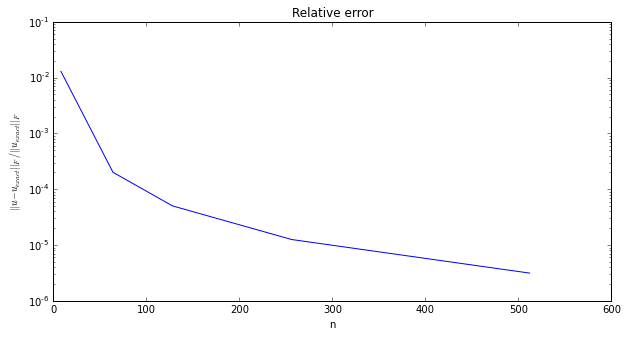

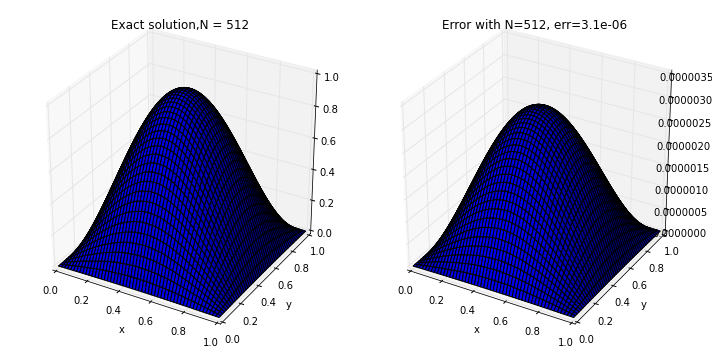

In [6]:
from mpl_toolkits.mplot3d import Axes3D

dims = np.array([8,64,128,256,512])
er = np.zeros(len(dims))

for i,n in enumerate(dims):
    A,f,sol_exact = init_linear_system(n)
    sol = linalg.spsolve(A,f)
    sol = np.array(sol).reshape(n-1,n-1)
    er[i] = np.linalg.norm(sol_exact - sol, 'fro') / np.linalg.norm(sol_exact, 'fro')


fig = plt.figure(figsize=(10,5))
plt.semilogy(dims,er)
plt.title('Relative error')
plt.xlabel('n')
plt.ylabel('$||u - u_{exact}||_F/||u_{exact}||_F$')
    
t = np.linspace(0,1,n)
x,y = np.meshgrid(t,t)
x = x[1:n,1:n]
y = y[1:n,1:n]


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x,y,sol_exact)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Exact solution,N = %d' %n)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x,y,sol - sol_exact)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Error with N=%d, err=%3.1e' % (n, er[len(dims)-1]))
fig.subplots_adjust()
fig.tight_layout()

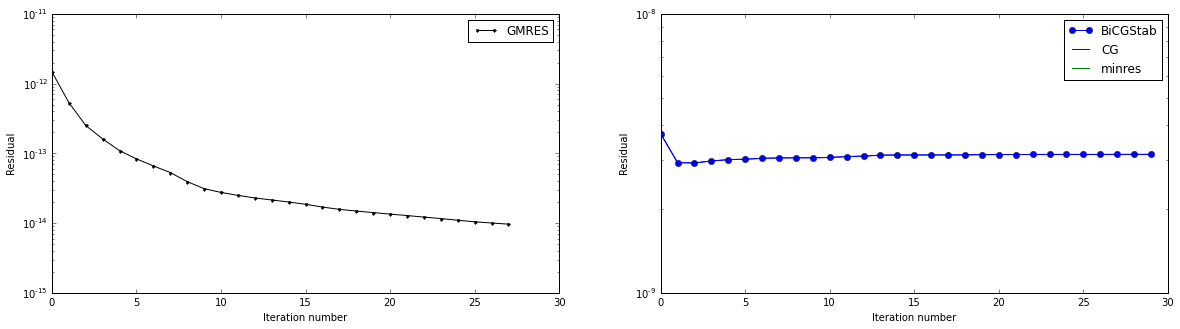

In [62]:
#results = [res_cg, res_minres,res_gmres,res_gmres_no,res_bicgstab]

n = 256
A,f,sol_exact = init_linear_system(n)
res_cg = [] 
res_minres = []
res_gmres = []
res_gmres_no = []
res_bicg = []
names = ['CG', 'minres','GMRES restart=','GMRES no restart','BiCGStab']

def my_print1(x): 
    res_cg.append(np.linalg.norm(A.dot(x) - f))

def my_print2(x): 
    res_minres.append(np.linalg.norm(A.dot(x) - f))
    
    
def my_print3(x): 
    res_bicg.append(np.linalg.norm(A.dot(x) - f))
    
sol1 = linalg.cg(A, f, tol = 1e-14, callback=my_print1)
sol2 = linalg.minres(A, f,callback=my_print2)
sol4 = linalg.gmres(A, f, restart=n, tol = 1e-14, callback=res_gmres.append)
sol5 = linalg.bicg(A, f, tol = 1e-14, callback=my_print3)

lim = 30
fig = plt.figure(figsize = (20,5))

plt.subplot(121)
plt.semilogy(res_gmres[:lim], marker='.',color='k', label='GMRES')
plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.legend(loc='best')

plt.subplot(122)
plt.semilogy(res_bicg[:lim], marker='o', color='b', label='BiCGStab')
plt.semilogy(res_cg[:lim],label = 'CG')
plt.semilogy(res_minres[:lim],label = 'minres')
plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.legend(loc='best')


For this system the best method is GMRES, it converges with monotonic decrease of residual. Other methods do not converge (There is a stagnation of error), but the solution is also close to exact.

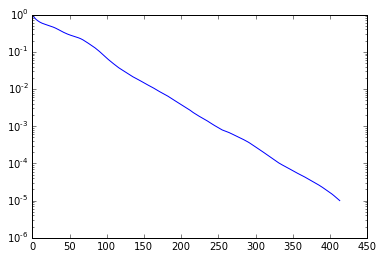

In [75]:
lu = linalg.spilu(A)
P = csr_matrix(lu.L.dot(lu.U))
res_ILUt = []
sol1 = linalg.gmres(P, f, restart=n, callback=res_ILUt.append)
plt.semilogy(res_ILUt,label = 'ILUt')
